In [1]:
!pip install pgmpy imbalanced-learn
!pip install scikit-learn
import pandas as pd 
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split #Training set partition function
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql.window import Window

import warnings 
warnings.filterwarnings(action='ignore')
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False #Used to display negative signs normally


#  Bayesian network
from pgmpy.estimators import HillClimbSearch, K2Score, BicScore,BayesianEstimator
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Decision tree
from sklearn.tree import DecisionTreeClassifier


# Up sampling
from imblearn.over_sampling import SMOTE


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
### Data preprocessing

#  Read data
spark = SparkSession.builder.appName("BrainStrokeAnalysis").getOrCreate()
data1 = spark.read.csv('./brain_stroke 11.csv', header=True, inferSchema=True)
data2 = spark.read.csv('./brain_stroke 22.csv', header=True, inferSchema=True)

#  Merge two pieces of data by id field
data2 = data2.drop('stroke')
data = data1.join(data2, on='ID')

data.printSchema()

# Obtain the number of missing values for each column
for column in data.columns:
    print(column, ":", data.filter(col(column).isNull()).count())


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/13 15:23:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- ID: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)

ID : 0
gender : 0
age : 0
hypertension : 0
heart_disease : 0
avg_glucose_level : 0
bmi : 0
smoking_status : 0
stroke : 0
ever_married : 0
work_type : 0
Residence_type : 0


In [4]:
from pyspark.sql import functions as F

# Delete missing values
data = data.na.drop()

# Using Three Sigma Rules to Detect and Replace Outliers
def replace_outliers_with_mean_in_spark(df, column_name):
    # Calculate mean and standard deviation
    mean_val = df.agg(F.mean(df[column_name])).first()[0]
    std_val = df.agg(F.stddev(df[column_name])).first()[0]
    lower_bound = mean_val - 3 * std_val
    upper_bound = mean_val + 3 * std_val

    # Replace outliers
    df = df.withColumn(column_name,
                       F.when((df[column_name] < lower_bound) | (df[column_name] > upper_bound), mean_val)
                       .otherwise(df[column_name]))
    return df

columns_to_check = ['age', 'avg_glucose_level', 'bmi']
for col in columns_to_check:
    data = replace_outliers_with_mean_in_spark(data, col)

In [5]:
from pyspark.sql.functions import col

data = data.withColumn('heart&hyper', col('heart_disease') + col('hypertension'))

print(data.columns)

['ID', 'gender', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke', 'ever_married', 'work_type', 'Residence_type', 'heart&hyper']


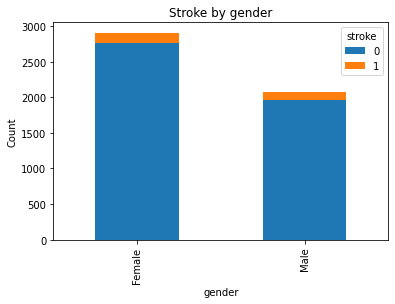

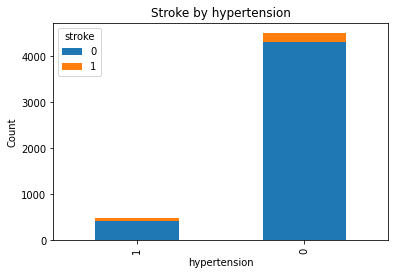

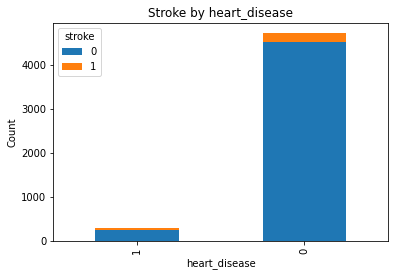

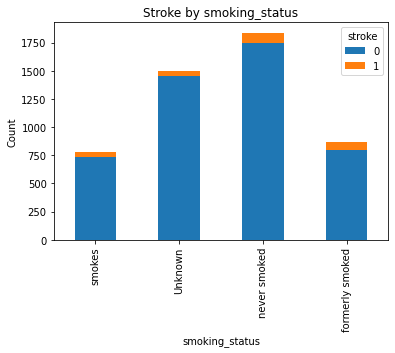

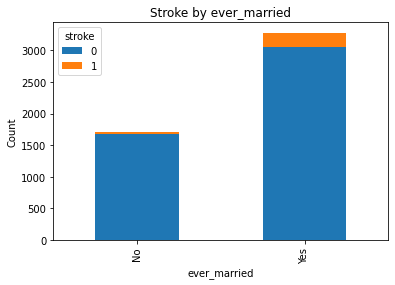

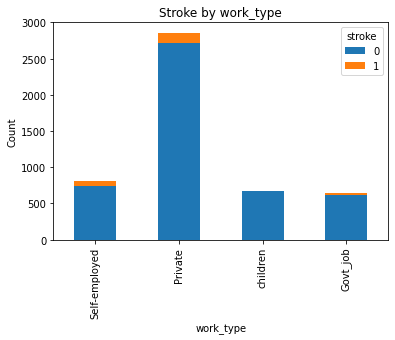

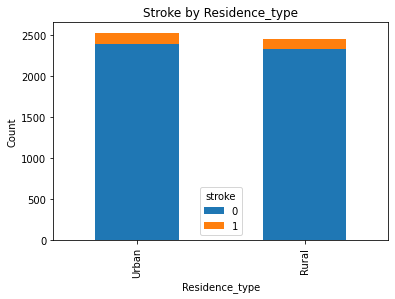

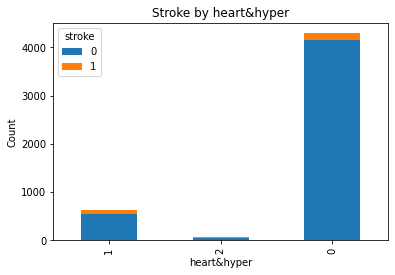

In [6]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt

def analyze_discrete_variables(df, x, stroke):
    # Create a crosstab using Spark's groupBy and pivot functions
    cross_table = df.groupBy(x).pivot(stroke).count().na.fill(0)
    
    # Convert Spark DataFrame to pandas DataFrame for plotting
    pd_cross_table = cross_table.toPandas().set_index(x)
    
    # Draw a stacked column chart using pandas
    pd_cross_table.plot(kind='bar', stacked=True)
    plt.xlabel(x)
    plt.ylabel('Count')
    plt.title(f'Stroke by {x}')
    plt.legend(title=stroke)
    plt.show()

##### ①gender
analyze_discrete_variables(data, 'gender', 'stroke')


##### ②hypertension
analyze_discrete_variables(data, 'hypertension', 'stroke')


##### ③heart_disease
analyze_discrete_variables(data, 'heart_disease', 'stroke')


##### ④smoking_status
analyze_discrete_variables(data, 'smoking_status', 'stroke')


##### ⑤ever_married
analyze_discrete_variables(data, 'ever_married', 'stroke')


##### ⑥work_type
analyze_discrete_variables(data, 'work_type', 'stroke')


#####  ⑦Residence_type
analyze_discrete_variables(data, 'Residence_type', 'stroke')


##### ⑧heart&hyper
analyze_discrete_variables(data, 'heart&hyper', 'stroke')




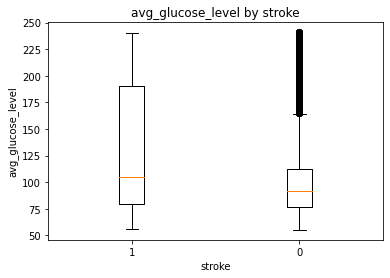

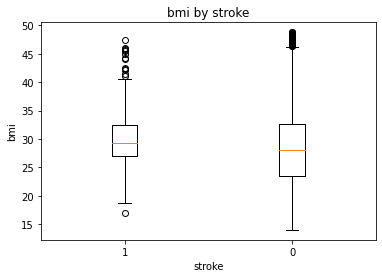

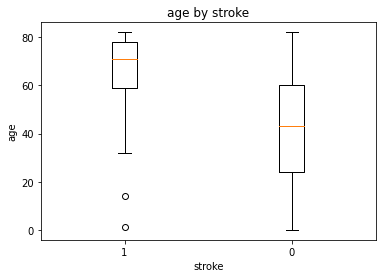

In [7]:
import matplotlib.pyplot as plt

def analyze_continuous_variable(df, x, stroke):
    # Using Spark's distinct function to obtain different values of stroke
    stroke_values = [row[stroke] for row in df.select(stroke).distinct().collect()]
    
    # Create a list to store data for the box plot
    boxplot_data = []
    
    # Traverse the different values of the discrete variable stroke
    for value in stroke_values:
        # Using Spark's filter function to obtain data for the continuous variable x with corresponding values
        x_data = df.filter(col(stroke) == value).select(x).rdd.flatMap(lambda r: r).collect()
        boxplot_data.append(x_data)
    
    # Drawing Box Diagram Using Matplotlib
    plt.boxplot(boxplot_data, labels=stroke_values)
    plt.xlabel(stroke)
    plt.ylabel(x)
    plt.title(f'{x} by {stroke}')
    plt.show()



#①avg_glucose_level
analyze_continuous_variable(data,'avg_glucose_level','stroke')

# The relationship between avg_glucose_level and stroke: 
# It can be seen that the average blood sugar levels of stroke patients are relatively high

#②bmi
analyze_continuous_variable(data,'bmi','stroke')

# The relationship between bmi and strokes: 
# As shown in the figure, the differentiation is not significant, that is, regardless of what the bmi are, 
# there is a relatively small proportion of strokes


#③age
analyze_continuous_variable(data,'age','stroke')

# The relationship between age and stroke: 
# It can be seen that the average age of stroke patients is relatively high

In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Gender feature transformation, converting Male to 0, otherwise 1
gender_udf = udf(lambda gender: 0 if gender == 'Male' else 1, IntegerType())
data = data.withColumn('gender', gender_udf(data['gender']))

# Smoking_ Status feature conversion
smoking_status_dict = {smoking_status: num for num, smoking_status in enumerate(data.select('smoking_status').distinct().rdd.flatMap(lambda x: x).collect())}
smoking_status_udf = udf(smoking_status_dict.get, IntegerType())
data = data.withColumn('smoking_status', smoking_status_udf(data['smoking_status']))

# Ever_ Married feature transformation
ever_married_udf = udf(lambda status: 0 if status == 'No' else 1, IntegerType())
data = data.withColumn('ever_married', ever_married_udf(data['ever_married']))

# Work_ Type feature transformation
work_type_dict = {work_type: num for num, work_type in enumerate(data.select('work_type').distinct().rdd.flatMap(lambda x: x).collect())}
work_type_udf = udf(work_type_dict.get, IntegerType())
data = data.withColumn('work_type', work_type_udf(data['work_type']))

# Residence_ Type feature transformation
residence_udf = udf(lambda residence: 0 if residence == 'Urban' else 1, IntegerType())
data = data.withColumn('Residence_type', residence_udf(data['Residence_type']))

# View converted data
data.show()

+---+------+----+------------+-------------+-----------------+------------------+--------------+------+------------+---------+--------------+-----------+
| ID|gender| age|hypertension|heart_disease|avg_glucose_level|               bmi|smoking_status|stroke|ever_married|work_type|Residence_type|heart&hyper|
+---+------+----+------------+-------------+-----------------+------------------+--------------+------+------------+---------+--------------+-----------+
|  1|     0|67.0|           0|            1|           228.69|              36.6|             3|     1|           1|        1|             0|          1|
|  2|     0|80.0|           0|            1|           105.92|              32.5|             2|     1|           1|        1|             1|          1|
|  3|     1|49.0|           0|            0|           171.23|              34.4|             0|     1|           1|        1|             0|          0|
|  4|     1|79.0|           1|            0|           174.12|              

23/10/13 15:24:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/13 15:24:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


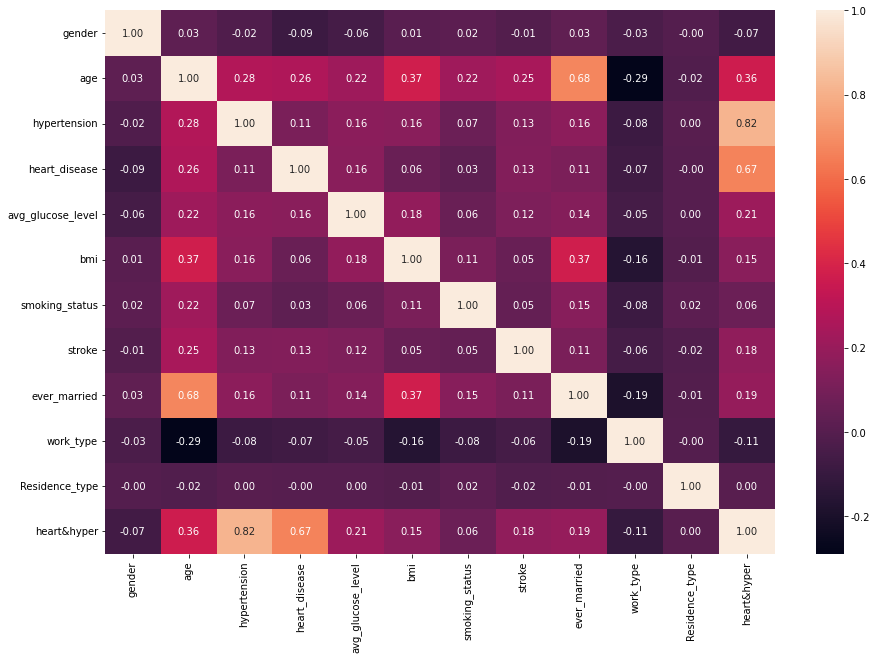

In [9]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert all features into a vector column
features = data.columns
features.remove('ID')
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(data)

# Using Spark's Correlation to Calculate Correlation
matrix = Correlation.corr(assembled_data, "features")

# Obtain the correlation matrix from the results
corr_matrix = matrix.head()[0].toArray()

# Convert to Pandas DataFrame
pd_corr_matrix = pd.DataFrame(corr_matrix, index=features, columns=features)

# Draw designs
plt.figure(figsize=(15,10))
sns.heatmap(pd_corr_matrix, annot=True, fmt=".2f")
plt.show()

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

# Combine all features into one vector
feature_cols = [col_name for col_name in data.columns if col_name not in ('ID', 'stroke')]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(data)

# Calculate Pearson correlation coefficient
pearson_matrix = Correlation.corr(assembled_data, "features").head()
correlation_array = pearson_matrix[0].toArray()

# Extract correlation coefficients related to 'stroke'
correlations_with_stroke = correlation_array[-1][:-1]  # Assuming stroke is the last feature

# Combining correlation with feature names
feature_correlation = list(zip(feature_cols, correlations_with_stroke))

# Sort by relevance
sorted_features = sorted(feature_correlation, key=lambda x: abs(x[1]), reverse=True)

# Print Results

for feature, correlation in sorted_features:
    print(feature, ":", correlation)

hypertension : 0.8160136849732157
heart_disease : 0.6657694605721016
age : 0.36289609169158826
avg_glucose_level : 0.21157270801986494
ever_married : 0.19030297566183613
bmi : 0.15423332544157933
work_type : -0.10567716535248983
gender : -0.06643448571708348
smoking_status : 0.06487143952169702
Residence_type : 0.002334099968180113


In [11]:
from pyspark.sql.functions import min, max
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import col, when

# Calculate the splits for avg_glucose_level
glucose_min, glucose_max = data.select(min("avg_glucose_level"), max("avg_glucose_level")).first()
glucose_range = glucose_max - glucose_min
glucose_splits = [glucose_min + i * (glucose_range / 4) for i in range(5)]

# Calculate the splits for age
age_min, age_max = data.select(min("age"), max("age")).first()
age_range = age_max - age_min
age_splits = [age_min + i * (age_range / 4) for i in range(5)]

# Calculate the splits for bmi
bmi_min, bmi_max = data.select(min("bmi"), max("bmi")).first()
bmi_range = bmi_max - bmi_min
bmi_splits = [bmi_min + i * (bmi_range / 4) for i in range(5)]

# Create Bucketizer objects
glucose_bucketizer = Bucketizer(splits=glucose_splits, inputCol="avg_glucose_level", outputCol="avg_glucose_level_temp")
age_bucketizer = Bucketizer(splits=age_splits, inputCol="age", outputCol="age_temp")
bmi_bucketizer = Bucketizer(splits=bmi_splits, inputCol="bmi", outputCol="bmi_temp")

# Transform the data
data = glucose_bucketizer.transform(data)
data = age_bucketizer.transform(data)
data = bmi_bucketizer.transform(data)

# Relabel the bucketed values to [0, 1, 2, 3]
data = data.withColumn("avg_glucose_level", when(col("avg_glucose_level_temp") == 0.0, 0)
            .otherwise(when(col("avg_glucose_level_temp") == 1.0, 1)
            .otherwise(when(col("avg_glucose_level_temp") == 2.0, 2)
            .otherwise(3))))

data = data.withColumn("age", when(col("age_temp") == 0.0, 0)
            .otherwise(when(col("age_temp") == 1.0, 1)
            .otherwise(when(col("age_temp") == 2.0, 2)
            .otherwise(3))))

data = data.withColumn("bmi", when(col("bmi_temp") == 0.0, 0)
            .otherwise(when(col("bmi_temp") == 1.0, 1)
            .otherwise(when(col("bmi_temp") == 2.0, 2)
            .otherwise(3))))

# Drop the temporary columns
data = data.drop("avg_glucose_level_temp", "age_temp", "bmi_temp")

# Select the final columns
col_end = ['stroke', 'age', 'heart&hyper', 'heart_disease', 'avg_glucose_level', 'hypertension', 'ever_married', 'bmi']

data_end = data.select(*col_end)

data_end.show()

+------+---+-----------+-------------+-----------------+------------+------------+---+
|stroke|age|heart&hyper|heart_disease|avg_glucose_level|hypertension|ever_married|bmi|
+------+---+-----------+-------------+-----------------+------------+------------+---+
|     1|  3|          1|            1|                3|           0|           1|  2|
|     1|  3|          1|            1|                1|           0|           1|  2|
|     1|  2|          0|            0|                2|           0|           1|  2|
|     1|  3|          1|            0|                2|           1|           1|  1|
|     1|  3|          0|            0|                2|           0|           1|  1|
|     1|  3|          2|            1|                0|           1|           1|  1|
|     1|  3|          0|            0|                0|           0|           0|  1|
|     1|  3|          0|            0|                0|           0|           1|  1|
|     1|  3|          1|            0|     

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('age', 'bmi'), ('age', 'heart&hyper'), ('age', 'stroke'), ('age', 'avg_glucose_level'), ('heart&hyper', 'hypertension'), ('heart&hyper', 'heart_disease'), ('hypertension', 'heart_disease'), ('ever_married', 'age')]


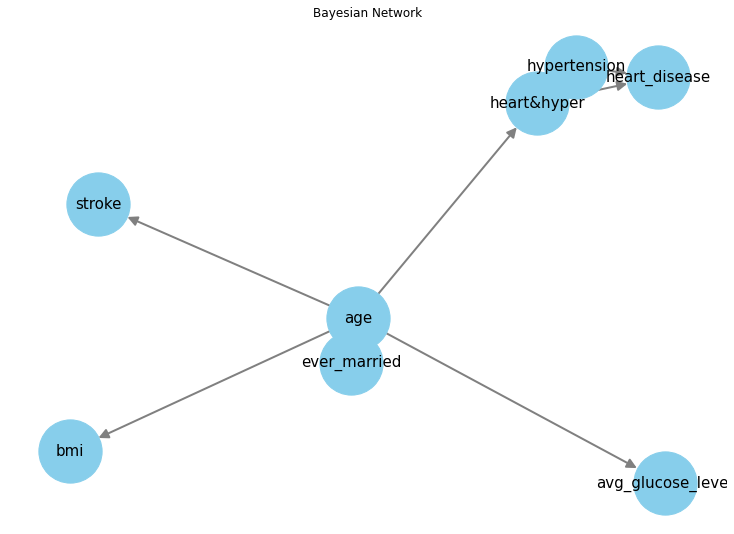

In [11]:
from pyspark.sql.functions import col
from pgmpy.estimators import HillClimbSearch, BicScore
import networkx as nx
import matplotlib.pyplot as plt

# Filter necessary columns
data_end = data.select(['stroke', 'age', 'heart&hyper', 'heart_disease', 'avg_glucose_level', 'hypertension', 'ever_married', 'bmi'])

# Split the data into train and test sets
train, test = data_end.randomSplit([0.7, 0.3], seed=400)

# Convert the training Spark DataFrame to Pandas DataFrame for pgmpy
pandas_train = train.toPandas()

# Use Hill Climbing and BIC Score for Structure Learning
hc = HillClimbSearch(pandas_train)
best_model = hc.estimate(scoring_method=BicScore(pandas_train))

print(best_model.edges())

# Visualization function
def showBN(model):
    G = nx.DiGraph()
    G.add_edges_from(model.edges())
    
    pos = nx.spring_layout(G)  # Using spring_ Layout
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, node_size=4000, node_color="skyblue", font_size=15, width=2, edge_color='gray', arrowsize=20)
    plt.title("Bayesian Network")
    plt.show()

# Display the Bayesian Network using networkx and matplotlib
showBN(best_model)

In [12]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

# Assuming train and test are already DataFrames in PySpark, as created above

# Use VectorAssembler to create a feature vector for train and test datasets
assembler = VectorAssembler(
    inputCols=['age', 'heart&hyper', 'heart_disease', 'avg_glucose_level', 'hypertension', 'ever_married', 'bmi'],
    outputCol="features")

train_assembled = assembler.transform(train)
test_assembled = assembler.transform(test)

# Train a Logistic Regression model (just as an example classifier)
lr = LogisticRegression(labelCol="stroke", featuresCol="features")
model = lr.fit(train_assembled)

# Predict using the trained model
predictions = model.transform(test_assembled)

# Rename 'stroke' column in predictions to 'true_label' to avoid ambiguity
predictions = predictions.withColumnRenamed("stroke", "true_label")

# Evaluate the predictions
evaluator = MulticlassClassificationEvaluator(labelCol="true_label", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")

# For the confusion matrix, you can use crosstab:
confusion_matrix = predictions.stat.crosstab("true_label", "prediction")
confusion_matrix.show()

Accuracy: 0.9475779694757797
Recall: 1.0
F1 Score: 0.9220724636534333
Precision: 0.8979040082358416
+---------------------+----+
|true_label_prediction| 0.0|
+---------------------+----+
|                    1|  79|
|                    0|1428|
+---------------------+----+



In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

# Use VectorAssembler to create a feature vector for train and test datasets
assembler = VectorAssembler(
    inputCols=train.columns[1:],  # Assuming the first column is the label
    outputCol="features")

# Create the Decision Tree classifier
dtc = DecisionTreeClassifier(labelCol=train.columns[0], featuresCol="features")

# Create a pipeline with the assembler and the classifier
pipeline = Pipeline(stages=[assembler, dtc])

# Fit the model to the training data
model = pipeline.fit(train)

# Make predictions on the test data
predictions = model.transform(test)

# For evaluations
evaluator = MulticlassClassificationEvaluator(labelCol=train.columns[0], predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})

print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)

# For the confusion matrix, you can use crosstab:
confusion_matrix = predictions.stat.crosstab(train.columns[0], "prediction")
confusion_matrix.show()

Accuracy: 0.9449236894492369
Recall: 0.9971988795518207
F1 Score: 0.9207444752872811
+-----------------+----+---+
|stroke_prediction| 0.0|1.0|
+-----------------+----+---+
|                1|  79|  0|
|                0|1424|  4|
+-----------------+----+---+



In [12]:
!pip install imbalanced-learn
from pyspark.sql import SparkSession
from imblearn.over_sampling import SMOTE
from pyspark.sql import DataFrame

def oversample_data_spark(df: DataFrame, column: str) -> DataFrame:
    # Convert Spark DataFrame to Pandas DataFrame
    pandas_df = df.toPandas()
    
    # Separate features and target variable
    X = pandas_df.drop(column, axis=1)
    y = pandas_df[column]
    
    # Instantiate SMOTE object
    oversampler = SMOTE()
    
    # Perform oversampling
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    
    # Recreate DataFrame
    df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=column)], axis=1)
    
    # Convert back to Spark DataFrame
    spark_session = SparkSession.builder.getOrCreate()
    spark_df_resampled = spark_session.createDataFrame(df_resampled)
    
    return spark_df_resampled

data_oversample = oversample_data_spark(data_end, 'stroke')

Defaulting to user installation because normal site-packages is not writeable


In [13]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F

# Calculate the count for each class
data_oversample.groupBy("stroke").count().show()

# If the order of the data has changed after oversampling, you can re-order the columns as follows
data_oversample = data_oversample.select(*data_end.columns)

# Randomly split the dataset into a 70-30 ratio
train_up, test_up = data_oversample.randomSplit([0.7, 0.3], seed=400)

+------+-----+
|stroke|count|
+------+-----+
|     0| 4733|
|     1| 4733|
+------+-----+



  0%|          | 0/1000000 [00:00<?, ?it/s]

[('age', 'ever_married'), ('age', 'stroke'), ('age', 'heart&hyper'), ('age', 'avg_glucose_level'), ('heart&hyper', 'hypertension'), ('heart&hyper', 'heart_disease'), ('heart&hyper', 'stroke'), ('heart_disease', 'avg_glucose_level'), ('hypertension', 'heart_disease'), ('ever_married', 'heart&hyper'), ('bmi', 'age')]


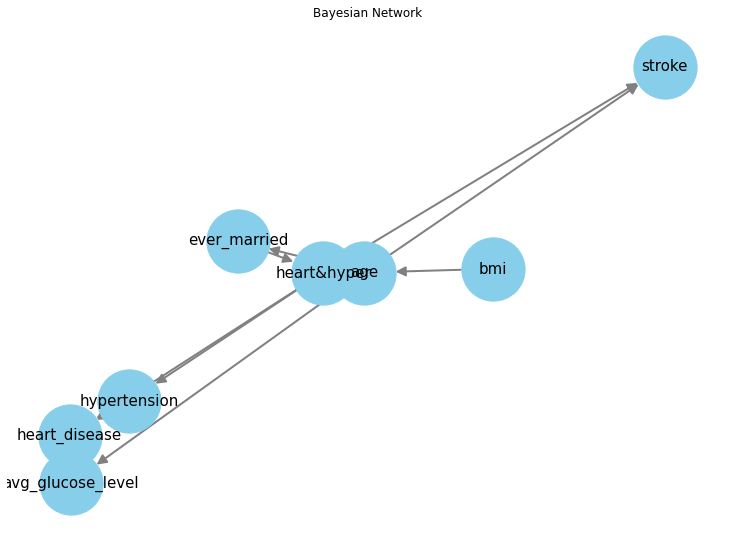

In [16]:
from pgmpy.estimators import HillClimbSearch, BicScore

# Convert Spark DataFrame to Pandas DataFrame
train_up_pd = train_up.toPandas()

# Use Hill Climbing for structure learning
hc1 = HillClimbSearch(train_up_pd)

# Estimate the model
best_model = hc1.estimate(scoring_method=BicScore(train_up_pd))
print(best_model.edges())

# Display the Bayesian Network
showBN(best_model)

In [17]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("BayesianNetwork").getOrCreate()

# 1. Train the Naive Bayes network model
# Use VectorAssembler to combine features into a vector column
vector_assembler = VectorAssembler(inputCols=train_up.columns, outputCol="features")
train_data = vector_assembler.transform(train_up)

# Create a NaiveBayes classifier
nb = NaiveBayes(featuresCol="features", labelCol="stroke")

# Train the model
model = nb.fit(train_data)

# 2. Use the model for prediction
# Prepare test data
test_data = vector_assembler.transform(test_up)

# Make predictions
y_pred_up = model.transform(test_data)

# 3. Evaluate model performance
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(y_pred_up)

# Print accuracy
print("Test set accuracy:", accuracy)

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score

true_labels = y_pred_up.select("stroke").rdd.flatMap(lambda x: x).collect()
predicted_labels = y_pred_up.select("prediction").rdd.flatMap(lambda x: x).collect()

# Calculate the confusion matrix and other performance metrics
cm = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print the confusion matrix and performance metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1 Score:", f1)

# Stop the Spark session
spark.stop()

Test set accuracy: 0.9149840595111584
Confusion Matrix:
 [[1188  240]
 [   0 1395]]
Accuracy: 0.9149840595111584
Recall: 1.0
F1 Score: 0.9207920792079208


In [16]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F

# Create a SparkSession
spark = SparkSession.builder.appName("DecisionTreeExample").getOrCreate()

# Assume train_up and test_up are already loaded Spark DataFrames

# Define feature columns
feature_columns = train_up.columns[1:]

# Use VectorAssembler to merge feature columns into a feature vector column with a different output column name "feature_vector"
assembler = VectorAssembler(inputCols=feature_columns, outputCol="feature_vector")
train_up = assembler.transform(train_up)
test_up = assembler.transform(test_up)

# Create a DecisionTreeClassifier model
dtc = DecisionTreeClassifier(labelCol="stroke", featuresCol="feature_vector")

# Fit the model on the training data
model = dtc.fit(train_up)

# Making predictions on test data
predictions = model.transform(test_up)

# Create a MulticlassClassificationEvaluator to evaluate model performance
evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")

# Calculation accuracy
accuracy = evaluator.evaluate(predictions)

# Calculate confusion matrix
TP = predictions.filter((F.col('stroke') == 1) & (F.col('prediction') == 1)).count()
TN = predictions.filter((F.col('stroke') == 0) & (F.col('prediction') == 0)).count()
FP = predictions.filter((F.col('stroke') == 0) & (F.col('prediction') == 1)).count()
FN = predictions.filter((F.col('stroke') == 1) & (F.col('prediction') == 0)).count()

confusion_matrix = [[TN, FP], [FN, TP]]

# Calculate recall rate
recall = TP / (TP + FN)

# Calculation accuracy
precision = TP / (TP + FP)

# Calculate F1 score
f1 = 2 * (precision * recall) / (precision + recall)

# Output Results
print("Accuracy:", accuracy)
print("Confusion Matrix:", confusion_matrix)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

Accuracy: 0.7573503365214311
Confusion Matrix: [[1026, 402], [283, 1112]]
Recall: 0.7971326164874551
Precision: 0.7344782034346103
F1 Score: 0.7645238913716055
